In [2]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

## Toy Model

### Model Specification

In [3]:
###Color palette
orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

###Helper functions
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

###Model definition
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

###Search space definition
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 0.001, 10), hp.uniform('k1_ur', 1E-7, 1E-3)], [2., hp.uniform('theta2_ur', 0.001, 10), hp.uniform('k2_ur', 1E-7, 1E-3)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 0.001, 10), hp.uniform('k1_nc', 1E-7, 1E-3)], [2., hp.uniform('theta2_nc', 0.001, 10), hp.uniform('k2_nc', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 0.001, 10), hp.uniform('k1_dc', 1E-7, 1E-3)], [2., hp.uniform('theta2_dc', 0.001, 10), hp.uniform('k2_dc', 1E-7, 1E-3)]])])
    

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E4, 100) 
        y0 = np.array([2290., 0., 0., 0., 0., 0.])

        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
        ode_solver = ode('cvode', toy_model, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)

        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'Circuit':circuits, 'Loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    landscape['Circuit'] = [name_converter(c) for c in landscape.Circuit]

    landscape = landscape.reset_index()

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.Loss[i] < best_loss:
            best_loss = landscape.Loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits
    return landscape, best

### Simulation Experiments

In [62]:
###Run single architecture search to impute landscape
max_iters = 500
landscape, best = run_hyperopt(max_iters)
landscape.to_csv('sample_run.csv')

100%|██████████| 500/500 [00:28<00:00, 17.60trial/s, best loss: 0.06496124236243211]


In [30]:
###Run single architecture search to impute landscape
max_iters = 1000

space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
da_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
ur_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
nc_landscape, best = run_hyperopt(max_iters)

space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
dc_landscape, best = run_hyperopt(max_iters)

landscape = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
landscape.to_csv('single_architecture_run.csv')

  5%|▌         | 52/1000 [00:04<01:04, 14.76trial/s, best loss: 0.06604478726228458]

job exception: <method-wrapper '__getattribute__' of EnumMeta object at 0x7f8b9a397750> returned a result with an error set

[CVODE ERROR]  CVode
  At t = 3464.93, the right-hand side routine failed in an unrecoverable manner.




  5%|▌         | 53/1000 [00:04<01:18, 12.05trial/s, best loss: 0.06604478726228458]


SystemError: <method-wrapper '__getattribute__' of EnumMeta object at 0x7f8b9a397750> returned a result with an error set

In [27]:
#Run single forward optimization grid search to create landscapes
architectures = [((0, 0, 1), (1, 0, 0)), ((0, 1, 0), (0, 0, 1)), ((0, 0, 1), (0, 0, 1)), ((0, 1, 0), (1, 0, 0))]
k1s = np.linspace(1E-7, 1E-3, 10)
k2s = np.linspace(1E-7, 1E-3, 10)
theta1s = np.linspace(0.001, 10, 10)
theta2s = np.linspace(0.001, 10, 10)
t = np.linspace(0, 5E4, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.])

landscape_grid = pd.DataFrame()
for architecture in architectures:
        for k1 in k1s:
                for k2 in k2s:
                        for theta1 in theta1s:
                                for theta2 in theta2s:
                                        param_values = [[2., theta1, k1], [2., theta2, k2]]
                                        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
                                        ode_solver = ode('cvode', toy_model, **extra_options)
                                        solution = ode_solver.solve(t, y0)
                                        j1, j2 = solution.values.y[-1, -2:]
                                        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
                                        test = pd.DataFrame({'index':[0], 'architecture':name_converter(architecture), 'theta1':theta1, 'theta2':theta2, 'k1':k1, 'k2':k2, 'loss':loss})
                                        landscape_grid = pd.concat([landscape_grid, test])
        print('architecture complete')
landscape_grid.to_csv('grid_search_landscape.csv')

architecture complete
architecture complete
architecture complete
architecture complete


In [44]:
###Run hyperopt 100 times to solve for background
max_iters = 500
total_background =  pd.DataFrame()
perturbs = [1., 1., 1.]
for i in range(100):
    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
    da_landscape, best = run_hyperopt(max_iters)
    
    space = hp.choice('architecture', 
        [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
        [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
        [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    background = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
    total_background = pd.concat([total_background, background])
    #background.to_csv('background.csv', mode='a')
    
total_background.to_csv('background.csv')

100%|██████████| 500/500 [00:31<00:00, 15.78trial/s, best loss: 0.06439194041413149]


### Visualization

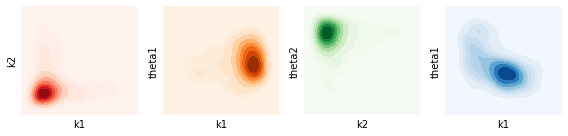

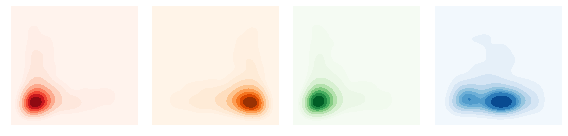

In [6]:
###FIGURE: Landscapes for each architecture
landscape = pd.read_csv('single_architecture_run.csv')
nc_landscape = landscape.loc[landscape.Circuit == 'No Control']
dc_landscape = landscape.loc[landscape.Circuit == 'Dual Control']
da_landscape = landscape.loc[landscape.Circuit == 'Downstream Activation']
ur_landscape = landscape.loc[landscape.Circuit == 'Upstream Repression']

fig, axs = plt.subplots(1,4,figsize=(8, 2))
landscapes = [nc_landscape, ur_landscape, da_landscape, dc_landscape]
colors = ['Reds','Oranges','Greens', 'Blues']
singlecolors = ['red', 'orange', 'green', 'blue']
xs = ['k1', 'k1', 'k2', 'k1']
ys = ['k2', 'theta1', 'theta2', 'theta1']

for i in range(4):
    landscape = landscapes[i]
    ax = axs[i]
    sns.kdeplot(data=landscape, x=xs[i], y =ys[i], cmap=colors[i], shade=True, thresh=0, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xs[i])
    ax.set_ylabel(ys[i])
    for spine in ax.spines.values():
        spine.set_edgecolor(None)

fig.tight_layout()
fig.savefig('landscapes_axes.png', dpi=300)

fig, axs = plt.subplots(1,4,figsize=(8, 2))
landscapes = [nc_landscape, ur_landscape, da_landscape, dc_landscape]
colors = ['Reds','Oranges','Greens', 'Blues']
singlecolors = ['red', 'orange', 'green', 'blue']
xs = ['k1', 'k1', 'k1', 'k1']
ys = ['k2', 'k2', 'k2', 'k2']

for i in range(4):
    landscape = landscapes[i]
    ax = axs[i]
    sns.kdeplot(data=landscape, x=xs[i], y =ys[i], cmap=colors[i], shade=True, thresh=0, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    for spine in ax.spines.values():
        spine.set_edgecolor(None)

fig.tight_layout()
fig.savefig('landscapes_noaxes.png', dpi=300)

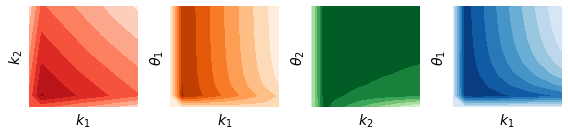

In [4]:
###FIGURE: Landscapes for each architecture from grid search
total_background = pd.read_csv('grid_search_landscape.csv')
k1s = total_background.k1.unique()
k2s = total_background.k2.unique()
theta1s = total_background.theta1.unique()
theta2s = total_background.theta2.unique()

fig, axs = plt.subplots(1,4,figsize=(8, 2))
colors = ['Reds_r','Oranges_r','Greens_r', 'Blues_r']
archs = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
singlecolors = ['red', 'orange', 'green', 'blue']
xs = ['k1', 'k1', 'k2', 'k1']
ys = ['k2', 'theta1', 'theta2', 'theta1']
xs_actual = [k1s, k1s, k2s, k1s]
ys_actual = [k2s, theta1s, theta2s, theta1s]
xs_names = ['$k_1$', '$k_1$', '$k_2$', '$k_1$']
ys_names = ['$k_2$', r'$\theta_1$', r'$\theta_2$', r'$\theta_1$']
for i in range(4):
    landscape = total_background.loc[total_background.architecture == archs[i]]
    loss_landscape = landscape.pivot_table(index=xs[i], columns=ys[i], values='loss').T.values
    ax = axs[i]
    contour = ax.contourf(xs_actual[i], ys_actual[i], loss_landscape, cmap=colors[i])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xs_names[i], fontsize=14)
    ax.set_ylabel(ys_names[i], fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor(None)

fig.tight_layout()
fig.savefig('landscapes_grid_search.png', dpi=300)

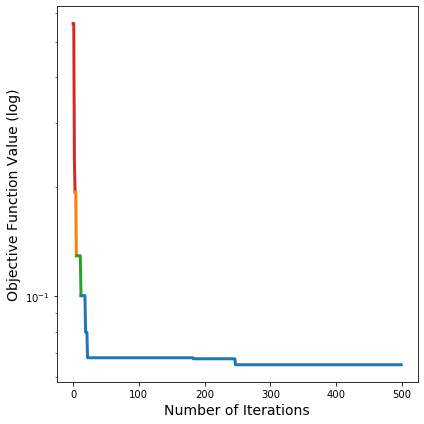

In [8]:
####FIGURE: Sample loss descent
landscape = pd.read_csv('sample_run.csv')
fig, ax = plt.subplots(1,1,figsize=(6, 6))
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

fig.tight_layout()
fig.savefig('sample_loss_descent.png', dpi=300)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


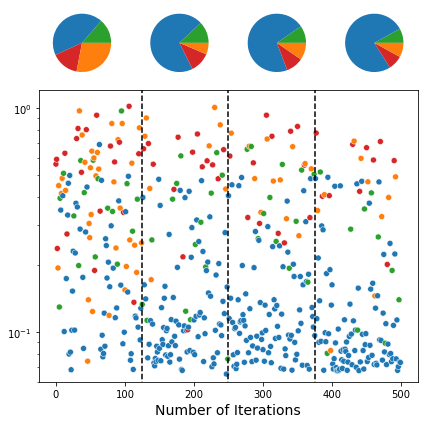

In [30]:
####FIGURE: Sample loss scatter and pie
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([60E-3, 1.2E0])
sns.scatterplot(x='index', y='Loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.vlines(125, 0, 10E9, linestyles='dashed')
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(375, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:125].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
quarter2 = (landscape.iloc[125:250].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
quarter3 = (landscape.iloc[250:375].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
quarter4 = (landscape.iloc[375:500].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.Loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.Loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.Loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.Loss, colors=colors)

fig.tight_layout()
fig.savefig('sample_loss_scatter_pie.png', dpi=300)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


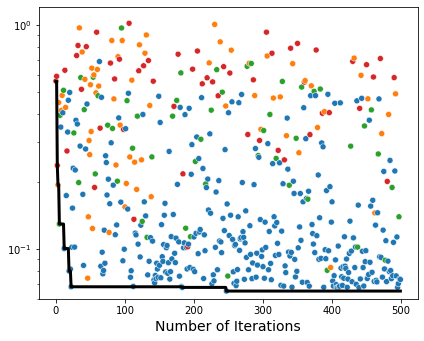

In [11]:
####FIGURE: Sample loss scatter and pie
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([60E-3, 1.2E0])
sns.scatterplot(x='index', y='Loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.plot(landscape.index, landscape.best_losses, color='k', linewidth=3)
# ax.vlines(125, 0, 10E9, linestyles='dashed')
# ax.vlines(250, 0, 10E9, linestyles='dashed')
# ax.vlines(375, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


# quarter1 = (landscape.iloc[0:125].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
# quarter2 = (landscape.iloc[125:250].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
# quarter3 = (landscape.iloc[250:375].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
# quarter4 = (landscape.iloc[375:500].sort_values(by='Circuit').groupby('Circuit').count().Loss/125).reset_index()
# colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

# ax = fig.add_subplot(gs[0, 0])
# ax.pie(quarter1.Loss, colors=colors)

# ax = fig.add_subplot(gs[0, 1])
# ax.pie(quarter2.Loss, colors=colors)

# ax = fig.add_subplot(gs[0, 2])
# ax.pie(quarter3.Loss, colors=colors)

# ax = fig.add_subplot(gs[0, 3])
# ax.pie(quarter4.Loss, colors=colors)

fig.tight_layout()
fig.savefig('loss_scatter_line.png', dpi=300)